Here we will be continuing the cystic fibrosis study, and examining the results in depth using the Python API.

In [1]:
import os
import qiime2
import numpy as np
import pandas as pd
from skbio import TreeNode
%matplotlib inline

# Obtain raw OTU counts
table_art = qiime2.Artifact.load('cfstudy_common_filt500.biom.qza')
table = table_art.view(pd.DataFrame)

# Obtain the balances
balance_art = qiime2.Artifact.load('cf_balances.qza')
balances = balance_art.view(pd.DataFrame)

# Obtain the tree
tree_art = qiime2.Artifact.load('ph_tree.nwk.qza')
tree = tree_art.view(TreeNode)

# Obtain the taxa
taxa_art = qiime2.Artifact.load('cfstudy_taxonomy.qza')
taxa = taxa_art.view(pd.DataFrame) 

# Obtain the metadata
metadata = pd.read_table('cfstudy_modified_metadata.txt', index_col=0)

# Unpack the results from the regression
viz = qiime2.Visualization.load('cf_linear_mixed_effects_model.qzv')
viz.export_data('regression_summary_dir')

pvals = pd.read_csv('regression_summary_dir/pvalues.csv', index_col=0)
resid = pd.read_csv('regression_summary_dir/residuals.csv', index_col=0)

We will visualize the entire tree, and resize the internal nodes reflect the pvalues with respect to ph. Specifically, we want to test to determine if pH is a driving factor.
We also want to visualize the mean ph values for each OTU and load the tree.

In [2]:
from gneiss.sort import mean_niche_estimator
mean_ph = mean_niche_estimator(table, metadata.ph)

Then we'll want to populate the tree with attributes that we would like to visualize.

In [3]:
for n in tree.postorder():
    n.color = '#FF00FF'  # color all nodes magenta    
    if n.is_tip():       # display mean ph in hover tool
        n.mean_ph = mean_ph.loc[n.name]         
    else:                # resize node by pvalue
        pval = pvals.loc[n.name, 'ph']
        n.ph_pvalue = -np.log(pval) / 10 # scale down for visual purposes

Now we can specify the machinery to visualize the plots.

In [4]:
from gneiss.plot import radialplot
from bokeh.io import show, output_notebook
output_notebook()
p = radialplot(tree, node_size='ph_pvalue', 
               node_color='color', edge_color='edge_color',
               hover_var='mean_ph')
show(p)

Loading BokehJS ...

Of course, we'll want to validate these findings by investigating the raw balances. We'll look at the most significant balance y1.

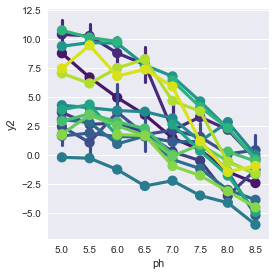

In [5]:
import seaborn as sns
data = pd.merge(balances, metadata, left_index=True, right_index=True)
grid = sns.factorplot(x="ph", y="y2", hue='host_subject_id', 
                      data=data, palette="viridis", legend=False)

Similar to the 88soils example, there is a very obvious transition from low pH organisms to high pH organism as the pH incrases. However, given that every patient has different microbes, so it is difficult to test for individual microbes abundances across patients. However, every patient has microbes that behave the same with respect to pH. Balances is a very powerful tool for addressing this, as it can allow for entire subcommunities to be tested, rather than just individual OTUs.